## Statistical Analysis of Gender on Wikipedia  
1. Load preselected sample pages from JSONs
2. Simplistically lump the JSONs into reductive gender groups for the sake of analysis. See published Medium article for our thoughts on how we've categorized gender within this code (TLDR we're not jazzed about it)
3. Figure out what gender categories we have! How are people identifying? How do we combine these into groups that yield interesting analysis while still acknowledging how varied gender identities are? 

We define two useful metrics for analysis: frequency and proportion. Frequency is the number of times a pronoun or keyword is mentioned on a page. Proportion is how many times that pronoun or keyword is mentioned on that page relative to other pronouns or keywords. The overview of population proportion data doesn’t yield a ton of super interesting insights, but I’ll point out a couple of parts.
1. The population mean and median for wf (female features) is basically half
2. Cisgender features are very rarely mentioned across the whole population despite most of the population being cisgender. This reinforces the idea that cisgender is a “default” and that gender identity is only worth discussing when someone violates that norm
3. The variance for female and male features is highest, which makes sense if we put pronouns on a gender binary. We expect that binary people’s pages are what creates the skew here.


In [1]:
import numpy as np
from scipy import stats
import statistics

import nltk
from collections import Counter
from nltk.corpus import stopwords 
from bs4 import BeautifulSoup as BS

from mwclient import Site
import requests

import pandas as pd

import matplotlib.pyplot as plt 
import json
from mwclient import Site
import csv
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import seaborn as sns

First, I'll load all the beautiful JSONs that Sarah made

In [2]:
with open('men-features.json', 'r') as fr:
    maleFF = json.load(fr)
    
with open('nb-features.json', 'r') as fr:
    nonbinaryFF = json.load(fr)

with open('trans-features.json', 'r') as fr:
    transFF = json.load(fr)
    
with open('women-features.json', 'r') as fr:
    femaleFF = json.load(fr)

with open('men-gender-proportions.json', 'r') as fr:
    maleProps = json.load(fr)
    
with open('nonbinary-gender-proportions.json', 'r') as fr:
    nonbinaryProps = json.load(fr)

with open('trans-gender-proportions.json', 'r') as fr:
    transProps = json.load(fr)
    
with open('women-gender-proportions.json', 'r') as fr:
    femaleProps = json.load(fr)
    
with open('population-features.json','r') as fr:
    allFF = json.load(fr)

allFrequencies = [maleFF,nonbinaryFF,transFF,femaleFF]
allProportions = [maleProps,nonbinaryProps,transProps,femaleProps]

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next, I'll grab some quick statistics about who we're working with! I decided to write all this code so it would automatically update as we added more JSON files.

In [3]:
i = 0
totalPeople = 0
while i < 4:
    totalPeople += len(allFrequencies[i])
    i += 1

features = ['wf','mf','nbf','cisf','transf'] # we broadly used these 5 categories, but they're obviously super reductive

totalMen = len(maleFF)
totalNB = len(nonbinaryFF)
totalTrans = 0                               # this is because we manually assigned an isTrans boolean to everybody
totalWomen = len(femaleProps)

for group in allFrequencies:                 # manually adding up everyone with the isTrans boolean == to True 
    for person in group:
        if person['isTrans'] == True:
            totalTrans += 1
            
'''figuring out what percent of our population is represented by the "four genders" weve classified here.
This number is important since we want to know what proportion each gender is for statistical analysis.
Youll notice if you run this code that the proportion of trans people is far larger than the general population.
This is intentional! We want to represent trans people well in this project, and the time constraints meant we
couldnt farm cis peoples pages for years to get a proportionate number of their wiki pages for the analysis.'''

menPercent = round((totalMen/totalPeople * 100), 2)         
womenPercent = round((totalWomen/totalPeople * 100), 2)
nonbinaryPercent = round((totalNB/totalPeople * 100), 2)
transPercent = round((totalTrans/totalPeople * 100), 2)

print('\n\nOur data set includes ' + str(totalPeople) + ' Wikipedia pages. This breaks down into:')
print('\t' + str(totalMen) + ' cisgender men,\t\t' + str(menPercent) + '% of our population;')
print('\t' + str(totalWomen) + ' cisgender women,\t\t' + str(womenPercent) + '% of our population;')
print('\t' + str(totalNB) + ' nonbinary people,\t\t' + str(nonbinaryPercent) + '% of our population;')
print('\t' + str(totalTrans) + ' transgender people,\t\t' + str(transPercent) + '% of our population;')
print('Nonbinary people can be trans, and trans people can be nonbinary. There is a lot of intentional overlap in our dataset.')



Our data set includes 1491 Wikipedia pages. This breaks down into:
	414 cisgender men,		27.77% of our population;
	634 cisgender women,		42.52% of our population;
	97 nonbinary people,		6.51% of our population;
	435 transgender people,		29.18% of our population;
Nonbinary people can be trans, and trans people can be nonbinary. There is a lot of intentional overlap in our dataset.


/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This helps us figure out what identities Wikipedia is representing well. Sarah populated this by hand, but I hope that one day Wikipedia will include some elective gender identifier for everybody (not just trans people)

In [4]:
identities = []

for group in allFrequencies:
    for person in group:
        currentG = person.get('Gender identity','None')
        identities.append(currentG)

allIdentities = Counter(identities)
genderIdentities = {}
genderIdentities['Man'] = allIdentities['Man']
genderIdentities['Woman'] = allIdentities['Woman']
genderIdentities['Non-binary'] = totalPeople - allIdentities['Man'] - allIdentities['Woman'] - allIdentities['None']
print(genderIdentities)

{'Man': 436, 'Woman': 705, 'Non-binary': 350}


/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Below I shamelessly stole Sarah's code

In [5]:
# Sarah wrote all of this

def getAvgProportions(featurePropDct):
    wfSum = 0.0
    mfSum = 0.0
    nbfSum = 0.0
    cisfSum = 0.0
    tfSum = 0.0
    denominator = len(featurePropDct)
    for personProp in featurePropDct:
        if 'wf' in featurePropDct[personProp]:
            wfSum += featurePropDct[personProp]['wf']
        if 'mf' in featurePropDct[personProp]:
            mfSum += featurePropDct[personProp]['mf']
        if 'nbf' in featurePropDct[personProp]:
            nbfSum += featurePropDct[personProp]['nbf']
        if 'cisf' in featurePropDct[personProp]:
            cisfSum += featurePropDct[personProp]['cisf']
        if 'tf' in featurePropDct[personProp]:
            tfSum += featurePropDct[personProp]['tf']
    avgPropDct = {'wf':wfSum/denominator, 'mf':mfSum/denominator, 'nbf':nbfSum/denominator,
                 'cisf':cisfSum/denominator, 'tf':tfSum/denominator}
        
    return avgPropDct

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Sarah

featuresDict = {'wf':["she", "her", "hers", "woman", "women", "female", "femme",
            "feminine"],
                'mf':["he", "him", "his", "man", "men", "male", "masculine", "masc"],
                'nbf':["they", "them", "their", "theirs", "xe", "xem", "xyr", "ze", "hir", "hirs",
             "ey", "em", "eir","queer", "non-binary", "gender non-conforming", "two-spirit",
           "hijra", "kinnar", "gender neutral",'they','them','their','theirs','themselves','ze',
 'hir','hir','hirs','hirself','ze','zir','zir','zirs','zirself','xey','xem','xyr',
 'xyrs','xemself','ae','aer','aer','aers','aerself','e','em','eir','eirs','emself','ey',
 'em','eir','eirs','eirself','fae','faer','faer','faers','faerself','fey','fem','feir',
 'feirs','feirself','hu','hum','hus','hus','humself','jee','jem','jeir','jeirs','jemself',
 'kit','kit','kits','kits','kitself','ne','nem','nir','nirs','nemself','peh',
 'pehm',"peh's","peh's",'pehself','per','per','per','pers','perself','sie','hir',
 'hir','hirs','hirself','se','sim','ser','sers','serself','shi','hir','hir','hirs','hirself','si','hyr','hyr','hyrs',
 'hyrself','they','them','their','theirs','themself','thon','thon','thons','thons','thonself','ve','ver',
 'vis','vis','verself','ve','vem','vir','virs','vemself','vi','ver','ver','vers','verself','vi','vim',
 'vir','virs','vimself','vi','vim','vim','vims','vimself','xie','xer','xer','xers','xerself','xe','xem',
 'xyr','xyrs','xemself','xey','xem','xeir','xeirs','xemself','yo','yo','yos','yos','yosself','ze','zem',
 'zes','zirself','ze','mer','zer','zers','zemself','zee','zed','zeta','zetas','zedself','zie',
 'zir','zirs','zirself','zie','zem','zes','zes','zirself','zie','hir','hir','hirs','hirself','zme','zmyr',
 'zmyr','zmyrs','zmyrself'],
                'cisf':["cis", "cisgender"],
                'tf':["trans", "transgender","transsexual"] }

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Some ugly calculations to figure out some quick stats. I wanted to reference these variables later, which is why I didn't just use a for loop to print the info.

In [7]:
wfProp = []
mfProp = []
nbfProp = []
cisfProp = []
transfProp = []
allProp = [wfProp,mfProp,nbfProp,cisfProp,transfProp]

wfPropMean = 0.0
mfPropMean = 0.0
nbfPropMean = 0.0
cisfPropMean = 0.0
transfPropMean = 0.0

wfPropMed = 0.0
mfPropMed = 0.0
nbfPropMed = 0.0
cisfPropMed = 0.0
transfPropMed = 0.0

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's figure out the mean proportions for each gender feature across our data set!

You'll notice some funky `percentWeight` variable down there. If I treated the six samples' means as if they were each worth 1/6 of the final value, I'd over weight cis people's proportions. Instead, I made sure that no sample's frequencies were disproportionally valued with a funky list comprehension/multiplication step.

In [8]:
def getPopulationProportions():
    j = 0
    while j < len(allProportions):
        current = allProportions[j]
        percentWeight = (len(current)/totalPeople * 100)
        avg = getAvgProportions(current)
        k = 0
        while k < percentWeight:
            wfProp.append(avg['wf'])
            mfProp.append(avg['mf'])
            nbfProp.append(avg['nbf'])
            cisfProp.append(avg['cisf'])
            transfProp.append(avg['tf'])
            k += 1
        j += 1

getPopulationProportions()

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


More ugly pseudo-hard coding. I did this because I need these variable later! I also figured this was most readable for a wide audience.

A recurring theme you’ll see throughout the statistics section is our hesitant use of “population” to describe our non-partitioned data. With unlimited computing power and time, we could scrape every single English-language Wikipedia biography page and use the true population of relevant Wikipedia pages. The scope of this project limited our web scraping, so when we refer to “population,” we mean the 1,491 Wikipedia pages included in our scripts.

In [9]:
wfPropMean = statistics.mean(wfProp)
mfPropMean = statistics.mean(mfProp)
nbfPropMean = statistics.mean(nbfProp)
cisfPropMean = statistics.mean(cisfProp)
transfPropMean = statistics.mean(transfProp)

wfPropMed = statistics.median(wfProp)
mfPropMed = statistics.median(mfProp)
nbfPropMed = statistics.median(nbfProp)
cisfPropMed = statistics.median(cisfProp)
transfPropMed = statistics.median(transfProp)

wfPropQuantiles = statistics.quantiles(wfProp)
mfPropQuantiles = statistics.quantiles(mfProp)
nbfPropQuantiles = statistics.quantiles(nbfProp)
cisfPropQuantiles = statistics.quantiles(cisfProp)
transfPropQuantiles = statistics.quantiles(transfProp)

wfPropStdDev = statistics.stdev(wfProp)
mfPropStdDev = statistics.stdev(mfProp)
nbfPropStdDev = statistics.stdev(nbfProp)
cisfPropStdDev = statistics.stdev(cisfProp)
transfPropStdDev = statistics.stdev(transfProp)

wfPropVar = statistics.variance(wfProp)
mfPropVar = statistics.variance(mfProp)
nbfPropVar = statistics.variance(nbfProp)
cisfPropVar = statistics.variance(cisfProp)
transfPropVar = statistics.variance(transfProp)

print('The population mean for...')
print('\twf:\t' + str(wfPropMean))
print('\tmf:\t' + str(mfPropMean))
print('\tnbf:\t' + str(nbfPropMean))
print('\tcisf:\t' + str(cisfPropMean))
print('\ttransf:\t' + str(transfPropMean))

print('\nThe population median for...')
print('\twf:\t' + str(wfPropMed))
print('\tmf:\t' + str(mfPropMed))
print('\tnbf:\t' + str(nbfPropMed))
print('\tcisf:\t' + str(cisfPropMed))
print('\ttransf:\t' + str(transfPropMed))

print('\nThe population standard deviation for...')
print('\twf:\t' + str(wfPropStdDev))
print('\tmf:\t' + str(mfPropStdDev))
print('\tnbf:\t' + str(nbfPropStdDev))
print('\tcisf:\t' + str(cisfPropStdDev))
print('\ttransf:\t' + str(transfPropStdDev))

print('\nThe population variance for...')
print('\twf:\t' + str(wfPropVar))
print('\tmf:\t' + str(mfPropVar))
print('\tnbf:\t' + str(nbfPropVar))
print('\tcisf:\t' + str(cisfPropVar))
print('\ttransf:\t' + str(transfPropVar))

print('\nThe population quantiles for...')
print('\twf:\t' + str(wfPropQuantiles))
print('\tmf:\t' + str(mfPropQuantiles))
print('\tnbf:\t' + str(nbfPropQuantiles))
print('\tcisf:\t' + str(cisfPropQuantiles))
print('\ttransf:\t' + str(transfPropQuantiles))

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The population mean for...
	wf:	0.466538828546518
	mf:	0.30882128625274496
	nbf:	0.11829364584834995
	cisf:	0.0004860616550217577
	transf:	0.06468094352494505

The population median for...
	wf:	0.4999001417936735
	mf:	0.1680594714069073
	nbf:	0.09343937766525856
	cisf:	0.0005482515529386139
	transf:	0.012601856558706973

The population standard deviation for...
	wf:	0.323290545547421
	mf:	0.3439709764677826
	nbf:	0.11228322241912307
	cisf:	0.00047534207050333187
	transf:	0.08722005750792684

The population variance for...
	wf:	0.10451677684034907
	mf:	0.11831603265219985
	nbf:	0.012607522036822263
	cisf:	2.259500839903945e-07
	transf:	0.007607338431686065

The population quantiles for...
	wf:	[0.011902024556448669, 0.4999001417936735, 0.7818435095171974]
	mf:	[0.05989349695544736, 0.1680594714069073, 0.8573415307363255]
	nbf:	[0.04821510318547289, 0.09343937766525856, 0.11246621918894058]
	cisf:	[0.0, 0.0005482515529386139, 0.0010244851591517518]
	transf:	[0.009460723600033727, 0.01260

Quick seaborn visual to show the distributions of gender feature frequency across the population.

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

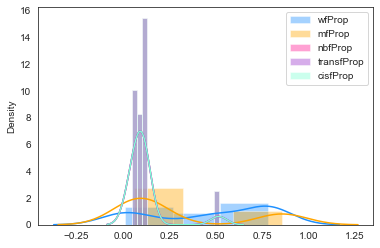

In [10]:
sns.set_style("white")

x1 = wfProp
x2 = mfProp
x3 = nbfProp
x4 = transfProp
x5 = cisfProp

plt.figure()
sns.distplot(x1, color="dodgerblue", label="wfProp")
sns.distplot(x2, color="orange", label="mfProp")
sns.distplot(x3, color="deeppink", label="nbfProp")
sns.distplot(x3, color="darkorchid", label="transfProp")
sns.distplot(x3, color="aquamarine", label="cisfProp")
plt.autoscale()
plt.legend()
plt.savefig('distribution')

I challenged myself to automate as much as possible so others could use the code easily. In the end, methods like `distributionVisualizer` was kind of a silly thing to automate.

It auto-generates a pretty graph showing **the normal distribution of the given proportion dict.** It's nice since all of the proportion dictionaries have visually similar graphs that pop our in similar places.

In [11]:
def distributionVisualizer(proportionDict):
    sns.set_style("white")

    currentWF = []
    currentMF = []
    currentNBF = []
    currentCisF = []
    currentTransF = []

    for person in proportionDict:
        if 'wf' in proportionDict[person]:
            currentWF.append(proportionDict[person]['wf'])
        
        if 'mf' in proportionDict[person]:
            currentMF.append(proportionDict[person]['mf'])
        
        if 'nbf' in proportionDict[person]:
            currentNBF.append(proportionDict[person]['nbf'])

        if 'cisf' in proportionDict[person]:
            currentCisF.append(proportionDict[person]['cisf'])
        
        if 'tf' in proportionDict[person]:
            currentTransF.append(proportionDict[person]['tf'])
    
    x1 = currentWF
    x2 = currentMF
    x3 = currentNBF
    x4 = currentCisF
    x5 = currentTransF

    plt.figure()
    sns.distplot(x1, color="dodgerblue", label="wfProp")
    sns.distplot(x2, color="orange", label="mfProp")
    sns.distplot(x3, color="deeppink", label="nbfProp")
    sns.distplot(x3, color="darkorchid", label="transfProp")
    sns.distplot(x3, color="aquamarine", label="cisfProp")
    plt.autoscale()
    plt.legend()
    plt.savefig('distribution')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now, let's make those visuals! Cumulative distributions are useful here since they show how similar our data are. These functions calculate the probability that data outside the sample would fall in a particular spot. Many statistics rely on certain distributions, so testing how our data is distributed first was important. These distributions cannot be characterized by a common distribution. You can see that some graphs have common peaks, but these peaks are not so distinct that we could say they belong to one distribution type or another. 

Notice the spikes around transgender language features. To us, it seems like if someone is trans, their Wikipedia page has to mention it. That’s not the case for cisgender people.

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

Distribution Visualizations

				maleProps: 

				nonbinaryProps: 


/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func


				transProps: 


/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func


				femaleProps: 


/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

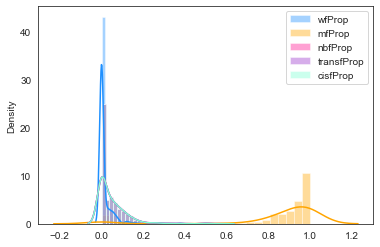

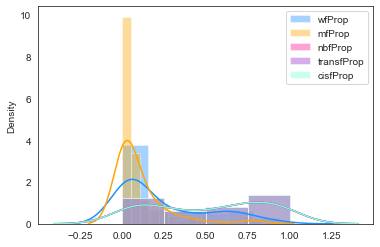

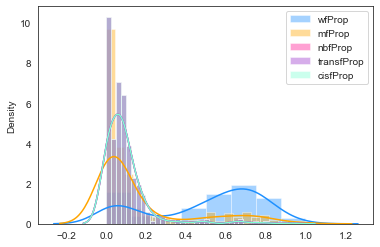

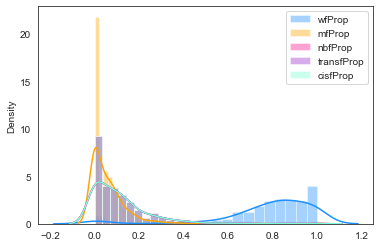

In [13]:
propNames = ['maleProps','nonbinaryProps','transProps','femaleProps'] # I hate hard coding

print('Distribution Visualizations')
i = 0
while (i < len(allProportions)):
    print('\n\t\t\t\t' + propNames[i] + ': ')
    distributionVisualizer(allProportions[i])
    i += 1

This tiny helper function lets us know if we're statistically significant. A significance value where alpha = 0.05 is hardcoded, since that value is widely accepted amongst standard publications.

In [14]:
def criticalP(pvalue):
    random = True
    if pvalue <= 0.05:
        random = False
    return random

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's perform a t-test! T-tests are one of the most common ways to compare the sample mean against the population mean. The null hypothesis for a t-test is that the sample mean is statistically identical to the population mean, while the alternative hypothesis is that the sample mean differs significantly from the population mean. The t-test results in a t-statistic and a p-value. The t-statistic allows you to reject or fail to reject the null hypothesis based on the size of the sample and your desired degree of certainty. In this project, we chose to use p-values to determine whether or not we should reject the null hypothesis. For all tests we use, if the p-value is below 0.05, we fail to accept the null hypothesis. The p-value is the probability that you could have gotten the same data you actually observed if the null hypothesis is correct. A 0.05 threshold means that there is a 5% chance or less that our data could be observed if the null hypothesis is correct. The print out will let us know if the means of each proportion dictionary are statistically significant from the population proportions.

In [39]:
def ttest(proportionDict):
    currentWF = []
    currentMF = []
    currentNBF = []
    currentCisF = []
    currentTransF = []

    for person in proportionDict:
        if 'wf' in proportionDict[person]:
            currentWF.append(proportionDict[person]['wf'])
        if 'mf' in proportionDict[person]:
            currentMF.append(proportionDict[person]['mf'])
        if 'nbf' in proportionDict[person]:
            currentNBF.append(proportionDict[person]['nbf'])
        if 'cisf' in proportionDict[person]:
            currentCisF.append(proportionDict[person]['cisf'])
        if 'tf' in proportionDict[person]:
            currentTransF.append(proportionDict[person]['tf'])
    
    print('T-test Scores:')
    print('\t\t    t-statistic\t\t\tp-value\t\t       random?')
    
    if (len(currentWF) > 0):
        wfTTest = stats.ttest_1samp(currentWF,wfPropMean)
        print('wf:\t\t' + str(wfTTest[0]) + '\t' + str(wfTTest[1]) + '\t\t' + str(criticalP(wfTTest[1])))
    else:
        print('No female features found in this dictionary')
    
    if (len(currentMF) > 0):
        mfTTest = stats.ttest_1samp(currentMF,mfPropMean)
        print('mf:\t\t' + str(mfTTest[0]) + '\t' + str(mfTTest[1]) + '\t\t' + str(criticalP(mfTTest[1])))
    else:
        print('No male features found in this dictionary')
    
    if (len(currentNBF) > 0):
        nbfTTest = stats.ttest_1samp(currentNBF,nbfPropMean)
        print('nbf:\t\t' + str(nbfTTest[0]) + '\t' + str(nbfTTest[1]) + '\t\t' + str(criticalP(nbfTTest[1])))
    else:
        print('No nonbinary features found in this dictionary')
    
    if (len(currentCisF) > 0):
        cisfTTest = stats.ttest_1samp(currentCisF,cisfPropMean)
        print('cisf:\t\t' + str(cisfTTest[0]) + '\t' + str(cisfTTest[1]) + '\t\t' + str(criticalP(cisfTTest[1])))
    else:
        print('No cisgender features found in this dictionary')
    
    if (len(currentTransF) > 0):
        transfTTest = stats.ttest_1samp(currentTransF,transfPropMean)
        print('transf:\t\t' + str(transfTTest[0]) + '\t' + str(transfTTest[1]) + '\t\t' + str(criticalP(transfTTest[1])))
    else: 
        print('No binary trans features found in this dictionary')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's run t-tests on all our dictionaries. If the `random?` column indicates `False`, we have met our critical p-value of 0.05. If the `random` column reads `True`, we have not met statistical significance.

You can see while looking at our t-test results that most of the sample means are statistically significant from the population means. The “random” column was my way of labeling whether or not we accept the null hypothesis—if the data was random, then the dependent variable didn’t actually impact our results. Throughout our analysis we found that cisgendered features were most likely to be irrelevant, and we think that’s because we only have two strings within that dictionary and most pages about cisgendered people don’t mention that they’re cisgender.

It's interesting that these data generally fail to meet significance only amongst cisgender features. Refer to our [Medium article](https://medium.com/@shurwitz/trans-on-wikipedia-the-code-is-binary-but-the-people-arent-465f965d5643) to read more about this.

In [16]:
propNames = ['maleProps','nonbinaryProps','transProps','femaleProps']

i = 0
while i < 4:
    print('\n\t\t\t\t' + propNames[i] + ': ')
    ttest(allProportions[i])
    i += 1


				maleProps: 
T-test Scores:
		    t-statistic			p-value		       random?
wf:		-289.7740776244449	0.0		False
mf:		43.71871823318542	4.88980783864876e-157		False
nbf:		-19.63602273084296	4.1339448863369394e-61		False
cisf:		0.14297932805620678	0.8863762371791946		True
transf:		-40.539625925167634	4.746957357093639e-146		False

				nonbinaryProps: 
T-test Scores:
		    t-statistic			p-value		       random?
wf:		-8.41285179634282	3.772039444579451e-13		False
mf:		-11.925645015380711	1.18226634272603e-20		False
nbf:		11.556296493328633	7.099907163138242e-20		False
cisf:		1.1371828407135423	0.2582923168997576		True
transf:		2.4459009996068564	0.016270224263714893		False

				transProps: 
T-test Scores:
		    t-statistic			p-value		       random?
wf:		2.1718041529329253	0.03057159903806472		False
mf:		-10.35152339105047	5.680206836568065e-22		False
nbf:		-3.7033983418267824	0.0002487090638303137		False
cisf:		2.402390927715109	0.016831996312264		False
transf:		17.046200817037185	2.35817930

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ah, the ruin of many statistics tests. Are our data normal? In a word: no. Testing for normality meant that I could determine which stats tests would be appropriate.

In [17]:
def testForNormality(dataArray):
    normal = None
    try:
        k, p = stats.normaltest(dataArray)
        if p <= 0.05:
            normal = False
        if p > 0.05:
            normal = True
    except ValueError as error:
        print(str(dataArray) + ' raised an error: ' + str(error)) 
    return normal

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


A funny quirk of the statistics library: most of the data you test on have to be *of the same length*. Ugh! I wrote this method to randomly sample whichever of the arrays is longer. I like that I get to call the method often down below, because it ensures that the results aren't reliant on a single call to create a random sample.

Default disclaimer: Yeah, numpy random != actually random.

In [18]:
def randomSample(independentArray,dependentArray):
    independentArray.sort()
    dependentArray.sort()
    ind = []
    d = []
    if (len(independentArray) != len(dependentArray)):
        if (len(independentArray) > len(dependentArray)):
            ind = np.random.choice(independentArray,len(dependentArray))
            return (ind,dependentArray)
        if (len(dependentArray) > len(independentArray)):
            d = np.random.choice(dependentArray,len(independentArray))
            return (independentArray,d)
    else:
        return(independentArray,dependentArray)

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pearson test time! Let's refer to the [scipy documentation:](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr)

> "The Pearson correlation coefficient measures the linear relationship between two datasets. The calculation of the p-value relies on the assumption that each dataset is normally distributed... Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases."

in my own words: Pearson Product-Moment Correlation Coefficient, also known as Pearson’s r or Pearson’s rho, is a statistic that measures the linear correlation between two variables: the dependent variable X and the independent variable Y. The coefficient ranges between -1, indicating the strongest negative correlation, and positive 1, the strongest positive correlation. A negative correlation means that as Y moves in one direction, X moves the same amount in the opposite direction. A positive correlation means that as Y moves in one direction, X moves the same amount in the same direction. Because Pearson’s r only ranges between -1 and 1, it’s invariant to scale and location changes of the variables, which was great as we were constantly messing with data and adding more pages.

Here's the catch: it really likes normally distributed data. I like the Pearson test a lot so I wrote a method for it anyway, but don't take its results at face value.

**Important! This first tests the correlation of the gender frequency proportions against the population proportions. There is a different method to test the correlation of the sample's proportions against the page length.**

In [19]:
def pearson(proportionDict):
    currentWF = []
    currentMF = []
    currentNBF = []
    currentCisF = []
    currentTransF = []

    for person in proportionDict:
        if 'wf' in proportionDict[person]:
            currentWF.append(proportionDict[person]['wf'])
        if 'mf' in proportionDict[person]:
            currentMF.append(proportionDict[person]['mf'])
        if 'nbf' in proportionDict[person]:
            currentNBF.append(proportionDict[person]['nbf'])
        if 'cisf' in proportionDict[person]:
            currentCisF.append(proportionDict[person]['cisf'])
        if 'tf' in proportionDict[person]:
            currentTransF.append(proportionDict[person]['tf'])
    
    print('Pearson Scores:')
    print('\t\t\t  r\t\t      p-value\t\trandom?')
    
    if (len(currentWF) > 0):
        i,d = randomSample(currentWF,wfProp)
        #if (testForNormality(i) == True):
        wfPearson = stats.pearsonr(i,d)
        print('wf:\t\t' + str(wfPearson[0]) + '\t' + str(wfPearson[1]) + '\t' + str(criticalP(wfPearson[1])))
        #else:
        #    print('currentWF is not normally distributed')
    else:
        print('No female features found in this dictionary')
    
    if (len(currentMF) > 0):
        i,d = randomSample(currentMF,mfProp)
        #if (testForNormality(i) == True):
        mfPearson = stats.pearsonr(i,d)
        print('mf:\t\t' + str(mfPearson[0]) + '\t' + str(mfPearson[1]) + '\t' + str(criticalP(mfPearson[1])))
        #else:
        #    print('currentMF is not normally distributed')
    else:
        print('No male features found in this dictionary')
    
    if (len(currentNBF) > 0):
        i,d = randomSample(currentNBF,nbfProp)
        #if (testForNormality(i) == True):
        nbfPearson = stats.pearsonr(i,d)
        print('nbf:\t\t' + str(nbfPearson[0]) + '\t' + str(nbfPearson[1]) + '\t' + str(criticalP(nbfPearson[1])))
        #else:
        #    print('currentNBF is not normally distributed')
    else:
        print('No nonbinary features found in this dictionary')
    
    if (len(currentCisF) > 0):
        i,d = randomSample(currentCisF,cisfProp)
        #if (testForNormality(currentCisF) == True):
        cisfPearson = stats.pearsonr(i,d)
        print('cisf:\t\t' + str(cisfPearson[0]) + '\t' + str(cisfPearson[1]) + '\t' + str(criticalP(cisfPearson[1])))
        #else:
        #    print('currentCisF is not normally distributed')
    else:
        print('No cisgender features found in this dictionary')
    
    if (len(currentTransF) > 0):
        i,d = randomSample(currentTransF,transfProp)
        #if (testForNormality(i) == True):
        transfPearson = stats.pearsonr(i,d)
        print('transf:\t\t' + str(transfPearson[0]) + '\t' + str(transfPearson[1]) + '\t' + str(criticalP(transfPearson[1])))
        #else:
        #    print('currentTransF is not normally distributed')
    else: 
        print('No binary trans features found in this dictionary')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


See! Look how many Pearson results fail to meet our critical values! I don't take this as a complete success because the data aren't normally distributed, but let's pretend that the data *should* be taken seriously.

We tested correlations between two sets of variables. The first set had the proportions amongst each gender group correlated against the population proportions. As you can see, there was no correlation between the two. You could not predict pronoun usage within individual gender groups based on pronoun usage on Wikipedia pages in general. This endorsed one of our main ideas: we talk about people differently depending on their gender. It’s the same idea as the t-test—pronoun usage is not standard across English—language Wikipedia.

In [20]:
print('Pearson test: pronoun frequences versus population frequences')
i = 0
while i < 4:
    print('\n\t\t\t\t' + propNames[i] + ': ')
    pearson(allProportions[i])
    i += 1

Pearson test: pronoun frequences versus population frequences

				maleProps: 
Pearson Scores:
			  r		      p-value		random?
wf:		0.0742862223757814	0.46033488676216205	True
mf:		0.13525443273005006	0.1774729768657855	True
nbf:		0.1699586119866271	0.08928375697383838	True
cisf:		0.013148441464329195	0.8961700302188688	True
transf:		-0.09363231479327913	0.3516837191848866	True

				nonbinaryProps: 
Pearson Scores:
			  r		      p-value		random?
wf:		-0.030081282284666347	0.7699106472396748	True
mf:		-0.21885398447248772	0.03126365945354967	False
nbf:		0.01308268877690142	0.8987942877821203	True
cisf:		0.09058185708240005	0.3775722131441229	True
transf:		-0.1075696118793147	0.2942930678755079	True

				transProps: 
Pearson Scores:
			  r		      p-value		random?
wf:		-0.08282832948384046	0.41024111925207485	True
mf:		0.007603908446987245	0.9398421865641117	True
nbf:		-0.10876721815954175	0.27893858627550316	True
cisf:		0.013148441464329195	0.8961700302188688	True
transf:		0.1065907251500

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


**This is the second Pearson test. It compares the frequency of gender features in each proportion dictionary against the length of the pages of the people in that dictionary.**

In [21]:
def pearson2(proportionDict):
    currentWF = []
    currentMF = []
    currentNBF = []
    currentCisF = []
    currentTransF = []
    
    characterCounts = []

    for person in proportionDict:
        characterCounts.append(findCount(person))
        if 'wf' in proportionDict[person]:
            currentWF.append(proportionDict[person]['wf'])
        else:
            currentWF.append(0)
        
        if 'mf' in proportionDict[person]:
            currentMF.append(proportionDict[person]['mf'])
        else:
            currentMF.append(0)
        
        if 'nbf' in proportionDict[person]:
            currentNBF.append(proportionDict[person]['nbf'])
        else:
            currentNBF.append(0)
        
        if 'cisf' in proportionDict[person]:
            currentCisF.append(proportionDict[person]['cisf'])
        else:
            currentCisF.append(0)
        
        if 'tf' in proportionDict[person]:
            currentTransF.append(proportionDict[person]['tf'])
        else:
            currentTransF.append(0)
    
    print('Pearson Scores:')
    print('\t\t\t  r\t\t      p-value\t\trandom?')
    
    if (len(currentWF) > 0):
        #if (testForNormality(i) == True):
        wfPearson = stats.pearsonr(currentWF,characterCounts)
        print('wf:\t\t' + str(wfPearson[0]) + '\t' + str(wfPearson[1]) + '\t' + str(criticalP(wfPearson[1])))
        #else:
        #    print('currentWF is not normally distributed')
    else:
        print('No female features found in this dictionary')
    
    if (len(currentMF) > 0):
        #if (testForNormality(i) == True):
        mfPearson = stats.pearsonr(currentMF,characterCounts)
        print('mf:\t\t' + str(mfPearson[0]) + '\t' + str(mfPearson[1]) + '\t' + str(criticalP(mfPearson[1])))
        #else:
        #    print('currentMF is not normally distributed')
    else:
        print('No male features found in this dictionary')
    
    if (len(currentNBF) > 0):
        #if (testForNormality(i) == True):
        nbfPearson = stats.pearsonr(currentNBF,characterCounts)
        print('nbf:\t\t' + str(nbfPearson[0]) + '\t' + str(nbfPearson[1]) + '\t' + str(criticalP(nbfPearson[1])))
        #else:
        #    print('currentNBF is not normally distributed')
    else:
        print('No nonbinary features found in this dictionary')
    
    if (len(currentCisF) > 0):
        #if (testForNormality(currentCisF) == True):
        cisfPearson = stats.pearsonr(currentCisF,characterCounts)
        print('cisf:\t\t' + str(cisfPearson[0]) + '\t' + str(cisfPearson[1]) + '\t' + str(criticalP(cisfPearson[1])))
        #else:
        #    print('currentCisF is not normally distributed')
    else:
        print('No cisgender features found in this dictionary')
    
    if (len(currentTransF) > 0):
        #if (testForNormality(i) == True):
        transfPearson = stats.pearsonr(currentTransF,characterCounts)
        print('transf:\t\t' + str(transfPearson[0]) + '\t' + str(transfPearson[1]) + '\t' + str(criticalP(transfPearson[1])))
        #else:
        #    print('currentTransF is not normally distributed')
    else: 
        print('No binary trans features found in this dictionary')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The first Pearson test didn't find correlation, but this second one did! The second correlation we tested had the proportions amongst each gender group correlated against the length of the person’s page. This had a few areas where there was a linear correlation. The longer the page, the more distinct pronoun usage was. This may be because longer pages have more paragraphs, and Wikipedia generally discourages pronoun usage at the beginning of paragraphs or sections. Longer pages may also be less likely to be written in a formal style that encourages the use of last names instead of pronouns.


In [40]:
print('Pearson test: pronoun frequences versus page length in characters')
i = 0
while i < 4:
    print('\n\t\t\t\t' + propNames[i] + ': ')
    pearson2(allProportions[i])
    i += 1

Pearson test: pronoun frequences versus page length in characters

				maleProps: 
Pearson Scores:
			  r		      p-value		random?
wf:		0.21942942712475327	6.597847725106625e-06	False
mf:		0.1343612575089665	0.006181280081393354	False
nbf:		0.16600708604123837	0.0006961513441523537	False
cisf:		9.488120420948504e-05	0.9984643046740848	True
transf:		0.18306526900248982	0.00018020527744270164	False

				nonbinaryProps: 
Pearson Scores:
			  r		      p-value		random?
wf:		0.40603902648972595	3.684829423162885e-05	False
mf:		0.18769528068363994	0.06561888646973615	True
nbf:		-0.28982157700388117	0.003983309550097621	False
cisf:		0.040572394432235495	0.6931572220040751	True
transf:		-0.03973845059868656	0.6991579705849864	True

				transProps: 
Pearson Scores:
			  r		      p-value		random?
wf:		-0.03041734166322754	0.578477595894632	True
mf:		0.07925789223470445	0.14714541324465555	True
nbf:		0.2031422383860716	0.00017758028198392093	False
cisf:		0.014858083227658619	0.7861194028473593	True

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


While Pearson’s rho test indicates linear correlation, Kendall’s tau coefficient is a statistic that shows **ordinal** correlation. If three people interview ten candidates for a job, and all rank Sophie as their first choice and all rank Paula as their second and so on, there is a strong ordinal correlation. If data is similarly ranked when examined by multiple quantities, it is ordinally correlated.  

We chose to use Kendall’s tau since it is non-parametric and isn’t affected by data that isn’t normally distributed, so we could use it to verify Pearson’s r results. You calculate the tau-statistic by subtracting the number of discordant pairs from the number of concordant pairs of data and dividing that number by n choose 2. The arrays were ordered by name as they appeared in our original files, so individuals who had none of a certain feature may have thrown off the test slightly. We took the slightly lazy route here and chose to mostly ignore the tau statistic and instead only look at the p-value in comparison to our threshold of alpha at 0.05. As you can see, the results are different from Pearson’s rho.  

We feel that because Kendall’s tau doesn’t rely on normally distributed data, we should favor these results. Gendered features, like pronouns and keywords we defined, are not correlated with neither page length nor population proportions. Again, this endorses our original hypothesis: the way we talk about someone’s gender depends on their gender identity. 

**This is the Kendall Tau test that tests correlation against population proportion.**

In [23]:
def kendallTau(proportionDict):
    currentWF = []
    currentMF = []
    currentNBF = []
    currentCisF = []
    currentTransF = []

    for person in proportionDict:
        if 'wf' in proportionDict[person]:
            currentWF.append(proportionDict[person]['wf'])
        if 'mf' in proportionDict[person]:
            currentMF.append(proportionDict[person]['mf'])
        if 'nbf' in proportionDict[person]:
            currentNBF.append(proportionDict[person]['nbf'])
        if 'cisf' in proportionDict[person]:
            currentCisF.append(proportionDict[person]['cisf'])
        if 'tf' in proportionDict[person]:
            currentTransF.append(proportionDict[person]['tf'])
    
    print('\t\tcorrelation\t\t\tp-value\t\t\trandom?')
    
    if (len(currentWF) > 0):
        i,d = randomSample(currentWF,wfProp)
        #if (testForNormality(i) == True):
        wfKT = stats.kendalltau(i,d)
        print('wf:\t\t' + str(wfKT[0]) + '\t\t' + str(wfKT[1]) + '\t' + str(criticalP(wfKT[1])))
        #else:
        #    print('currentWF is not normally distributed')
    else:
        print('No female features found in this dictionary')
    
    if (len(currentMF) > 0):
        i,d = randomSample(currentMF,mfProp)
        #if (testForNormality(i) == True):
        mfKT = stats.kendalltau(i,d)
        print('mf:\t\t' + str(mfKT[0]) + '\t\t' + str(mfKT[1]) + '\t' + str(criticalP(mfKT[1])))
        #else:
        #    print('currentMF is not normally distributed')
    else:
        print('No male features found in this dictionary')
    
    if (len(currentNBF) > 0):
        i,d = randomSample(currentNBF,nbfProp)
        #if (testForNormality(i) == True):
        nbfKT = stats.kendalltau(i,d)
        print('nbf:\t\t' + str(nbfKT[0]) + '\t\t' + str(nbfKT[1]) + '\t' + str(criticalP(nbfKT[1])))
        #else:
        #    print('currentNBF is not normally distributed')
    else:
        print('No nonbinary features found in this dictionary')
    
    if (len(currentCisF) > 0):
        i,d = randomSample(currentCisF,cisfProp)
        #if (testForNormality(i) == True):
        cisfKT = stats.kendalltau(i,d)
        print('cisf:\t\t' + str(cisfKT[0]) + '\t\t' + str(cisfKT[1]) + '\t' + str(criticalP(cisfKT[1])))
        #else:
        #    print('currentCisF is not normally distributed')
    else:
        print('No cisgender features found in this dictionary')
    
    if (len(currentTransF) > 0):
        i,d = randomSample(currentTransF,transfProp)
        #if (testForNormality(i) == True):
        transfKT = stats.kendalltau(i,d)
        print('transf:\t\t' + str(transfKT[0]) + '\t\t' + str(transfKT[1]) + '\t' + str(criticalP(transfKT[1])))
        #else:
        #    print('currentTransF is not normally distributed')
    else: 
        print('No binary trans features found in this dictionary')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
print('Kendall Tau - pronoun frequencies versus population frequency means')
i = 0
while i < 4:
    print('\n' + propNames[i] + ' Kendall Tau scores: ')
    kendallTau(allProportions[i])
    i += 1

Kendall Tau - pronoun frequencies versus population frequency means

maleProps Kendall Tau scores: 
		correlation			p-value			random?
wf:		-0.049793552927620464		0.5652608971458692	True
mf:		0.009593642059339812		0.9007282705728566	True
nbf:		-0.07464248146662537		0.3625025765615745	True
cisf:		nan		nan	True
transf:		-0.052792717793435626		0.5494327021195322	True

nonbinaryProps Kendall Tau scores: 
		correlation			p-value			random?
wf:		-0.1675691572579761		0.035392649625845714	False
mf:		-0.07087775416640785		0.3841945628481228	True
nbf:		-0.03789739254000491		0.6281883322926404	True
cisf:		-0.026925366629748107		0.7743516043848474	True
transf:		-0.1563404638548973		0.05395434696979974	True

transProps Kendall Tau scores: 
		correlation			p-value			random?
wf:		-0.04563565056432766		0.5515980773901548	True
mf:		0.010623094969146263		0.892362910700078	True
nbf:		-0.031653818183117396		0.6840175509693921	True
cisf:		0.005846609292077971		0.9491733183563951	True
transf:		0.1101770720538

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**And this is the kendall tau test for sample proportions against sample page length.**

In [25]:
def kendallTau2(proportionDict):
    currentWF = []
    currentMF = []
    currentNBF = []
    currentCisF = []
    currentTransF = []
    
    characterCounts = []

    for person in proportionDict:
        characterCounts.append(findCount(person))
        if 'wf' in proportionDict[person]:
            currentWF.append(proportionDict[person]['wf'])
        else:
            currentWF.append(0)
        
        if 'mf' in proportionDict[person]:
            currentMF.append(proportionDict[person]['mf'])
        else:
            currentMF.append(0)
        
        if 'nbf' in proportionDict[person]:
            currentNBF.append(proportionDict[person]['nbf'])
        else:
            currentNBF.append(0)
        
        if 'cisf' in proportionDict[person]:
            currentCisF.append(proportionDict[person]['cisf'])
        else:
            currentCisF.append(0)
        
        if 'tf' in proportionDict[person]:
            currentTransF.append(proportionDict[person]['tf'])
        else:
            currentTransF.append(0)
    
    print('\t\tcorrelation\t\t\tp-value\t\t\trandom?')
    
    if (len(currentWF) > 0):
        #if (testForNormality(i) == True):
        wfKT = stats.kendalltau(currentWF,characterCounts)
        print('wf:\t\t' + str(wfKT[0]) + '\t\t' + str(wfKT[1]) + '\t' + str(criticalP(wfKT[1])))
        #else:
        #    print('currentWF is not normally distributed')
    else:
        print('No female features found in this dictionary')
    
    if (len(currentMF) > 0):
        #if (testForNormality(i) == True):
        mfKT = stats.kendalltau(currentMF,characterCounts)
        print('mf:\t\t' + str(mfKT[0]) + '\t\t' + str(mfKT[1]) + '\t' + str(criticalP(mfKT[1])))
        #else:
        #    print('currentMF is not normally distributed')
    else:
        print('No male features found in this dictionary')
    
    if (len(currentNBF) > 0):
        #if (testForNormality(i) == True):
        nbfKT = stats.kendalltau(currentNBF,characterCounts)
        print('nbf:\t\t' + str(nbfKT[0]) + '\t\t' + str(nbfKT[1]) + '\t' + str(criticalP(nbfKT[1])))
        #else:
        #    print('currentNBF is not normally distributed')
    else:
        print('No nonbinary features found in this dictionary')
    
    if (len(currentCisF) > 0):
        #if (testForNormality(i) == True):
        cisfKT = stats.kendalltau(currentCisF,characterCounts)
        print('cisf:\t\t' + str(cisfKT[0]) + '\t\t' + str(cisfKT[1]) + '\t' + str(criticalP(cisfKT[1])))
        #else:
        #    print('currentCisF is not normally distributed')
    else:
        print('No cisgender features found in this dictionary')
    
    if (len(currentTransF) > 0):
        #if (testForNormality(i) == True):
        transfKT = stats.kendalltau(currentTransF,characterCounts)
        print('transf:\t\t' + str(transfKT[0]) + '\t\t' + str(transfKT[1]) + '\t' + str(criticalP(transfKT[1])))
        #else:
        #    print('currentTransF is not normally distributed')
    else: 
        print('No binary trans features found in this dictionary')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
print('Kendall Tau - pronoun frequencies versus page lengths in characters')
i = 0
while i < 4:
    print('\n' + propNames[i] + ' Kendall Tau scores: ')
    kendallTau(allProportions[i])
    i += 1

Kendall Tau - pronoun frequencies versus page lengths in characters

maleProps Kendall Tau scores: 
		correlation			p-value			random?
wf:		-0.07890527732539479		0.37038087546330245	True
mf:		0.040557473092124964		0.5962432937420558	True
nbf:		-0.16698916109249898		0.042505880070403707	False
cisf:		-0.09810799573376047		0.29156929006214405	True
transf:		-0.02792042802266898		0.75083407713266	True

nonbinaryProps Kendall Tau scores: 
		correlation			p-value			random?
wf:		-0.09218520656706007		0.24234827708779683	True
mf:		0.10238335698100356		0.2082986071041656	True
nbf:		0.027298903104470255		0.7258015673721754	True
cisf:		-0.02355871250520962		0.8027240832321169	True
transf:		-0.0465296928752143		0.5702936749814923	True

transProps Kendall Tau scores: 
		correlation			p-value			random?
wf:		0.024341748241880484		0.7505701316166515	True
mf:		-0.059869231542017724		0.4524289482584971	True
nbf:		0.10098597058272901		0.19387748775745484	True
cisf:		0.09996828545956107		0.2753926460511229	

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This `findCount()` helper method figures out the length of the person's wikipedia page, which helps us in our stats tests.

In [27]:
def findCount(name):
    for person in allFF:
        if person['Name'] == name:
            return person['Char Count']
    return 0

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


`printLR()` just helps us print the crazy info that prints with my manually-written linear regression method.

In [28]:
def printLR(name,stat):
    s = str(round(stat['slope'],5)) + '\t\t'
    i = str(round(stat['intercept'],5)) + '\t'
    r = str(round(stat['rvalue'],5)) + '\t\t'
    p = str(round(stat['pvalue'],5)) + '\t'
    e = str(round(stat['stderr'],5)) + '\t'
    rand = str(criticalP(stat['pvalue']))
    
    print(name + ':\t' + s + i + r + p + e + rand)

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We calculated the linear regression models for gendered group proportions against the lengths of pages in characters. Interestingly enough, the data are pretty strongly linearly correlated! These p-values have all been rounded down to 0, indicating that it would be impossible to get the same data if the two variables were not correlated. The scale has been adjusted on each graph to show the prediction results most clearly.

- You can see that on men’s pages, male pronouns are quite common and female pronouns are quite uncommon. Cisgendered features are rarely mentioned. Nonbinary features are positively correlated—we used “they” as a nonbinary feature and could not figure out how to differentiate the plural they from the singular they—and we think that men notable for the ensemble or group they were in have page space occupied by their accomplishments with others.
- Nonbinary pages have a somewhat even distribution of male and female features. Nonbinary features are negatively correlated against page length, which may be because editors feel more comfortable using someone’s last name instead of using the singular “they” or neopronouns.
- Female features are negatively correlated on transgender peoples’ pages while male features are positively correlated. Transgender features are also negatively correlated. We think that this may be because a longer page allows for editors to write about more than just a trans person’s gender.
- Male pronouns are relatively common on women’s pages, and female features are negatively correlated on women’s pages. We think these two correlations are because women’s pages often include lots of information about their husbands and male coworkers. Nonbinary features are prominant too, so we again think that women’s pages often credit group work more than men’s pages do.

The first LR method tests against the length of the page. The second makes pretty grahps.

*one may ask: why did we hard code a linear regression method? because I didn't love the objects other linear regression methods returned, and I'm silly.*

In [29]:
def linearRegression(proportionDict):
    currentWF = []
    currentMF = []
    currentNBF = []
    currentCisF = []
    currentTransF = []
    characterCounts = []
    
    wfLinReg = {}
    mfLinReg = {}
    nbfLinReg = {}
    cisfLinReg = {}
    transfLinReg = {}

    for person in proportionDict:
        characterCounts.append(findCount(person))
        if 'wf' in proportionDict[person]:
            currentWF.append(proportionDict[person]['wf'])
        else:
            currentWF.append(0)
        
        if 'mf' in proportionDict[person]:
            currentMF.append(proportionDict[person]['mf'])
        else:
            currentMF.append(0)
        
        if 'nbf' in proportionDict[person]:
            currentNBF.append(proportionDict[person]['nbf'])
        else:
            currentNBF.append(0)
        
        if 'cisf' in proportionDict[person]:
            currentCisF.append(proportionDict[person]['cisf'])
        else:
            currentCisF.append(0)
        
        if 'tf' in proportionDict[person]:
            currentTransF.append(proportionDict[person]['tf'])
        else:
            currentTransF.append(0)
    
    print('\tslope\t\t\tintercept\trvalue\t\tpvalue\tstderr\t\trandom?')
    
    if (len(currentWF) > 0):
        i,d = randomSample(currentWF,characterCounts)
        wfLinReg['slope'],wfLinReg['intercept'],wfLinReg['rvalue'],wfLinReg['pvalue'],wfLinReg['stderr'] = stats.linregress(i,d)
        printLR('wf',wfLinReg)
    else:
        print('No female features found in this dictionary')
    
    if (len(currentMF) > 0):
        i,d = randomSample(currentMF,characterCounts)
        mfLinReg['slope'],mfLinReg['intercept'],mfLinReg['rvalue'],mfLinReg['pvalue'],mfLinReg['stderr'] = stats.linregress(i,d)
        printLR('mf',mfLinReg)
    else:
        print('No male features found in this dictionary')
    
    if (len(currentNBF) > 0):
        i,d = randomSample(currentNBF,characterCounts)
        nbfLinReg['slope'],nbfLinReg['intercept'],nbfLinReg['rvalue'],nbfLinReg['pvalue'],nbfLinReg['stderr'] = stats.linregress(i,d)
        printLR('nbf',nbfLinReg)
    else:
        print('No nonbinary features found in this dictionary')
        
    if (len(currentCisF) > 0):
        i,d = randomSample(currentCisF,characterCounts)
        cisfLinReg['slope'],cisfLinReg['intercept'],cisfLinReg['rvalue'],cisfLinReg['pvalue'],cisfLinReg['stderr'] = stats.linregress(i,d)
        printLR('cisf',cisfLinReg)
    else:
        print('No cisgender features found in this dictionary')
        
    if (len(currentTransF) > 0):
        i,d = randomSample(currentTransF,characterCounts)
        transfLinReg['slope'],transfLinReg['intercept'],transfLinReg['rvalue'],transfLinReg['pvalue'],transfLinReg['stderr'] = stats.linregress(i,d)
        printLR('transf',transfLinReg)
    else:
        print('No binary transgender features found in this dictionary')
    

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Interesting! 

1. Check out those SLOPES! Very, very steep. Looks like there's some crazy strong correlation there.
2. I double checked that those p-values aren't mistakes. Again, very strong correlation,
3. Another `random?` column, to emphasize the CORRELATION!!

In [30]:
i = 0
while i < 4:
    print('\n' + propNames[i] + ' Linear Regression: ')
    linearRegression(allProportions[i])
    i += 1


maleProps Linear Regression: 
	slope			intercept	rvalue		pvalue	stderr		random?
wf:	493771.29604		8198.83205	0.96544		0.0	6566.75742	False
mf:	23852.40175		-6373.94448	0.37295		0.0	2923.53721	False
nbf:	214555.70834		3730.88453	0.95426		0.0	3311.75787	False
cisf:	1123662.03201		13459.66069	0.60908		0.0	72084.16493	False
transf:	550758.12816		8865.13972	0.93492		0.0	10298.86874	False

nonbinaryProps Linear Regression: 
	slope			intercept	rvalue		pvalue	stderr		random?
wf:	52188.51942		2523.21757	0.8864		0.0	2796.3506	False
mf:	91561.84324		5235.78101	0.97438		0.0	2168.46188	False
nbf:	34223.77812		-2686.49729	0.73845		0.0	3206.25187	False
cisf:	2757726.89133		12150.07962	0.81851		0.0	198589.63122	False
transf:	118334.77498		3537.98381	0.96965		0.0	3061.51684	False

transProps Linear Regression: 
	slope			intercept	rvalue		pvalue	stderr		random?
wf:	29034.74926		-3684.72229	0.61809		0.0	2020.59591	False
mf:	44043.80288		3427.77474	0.82999		0.0	1619.56109	False
nbf:	101702.55687		1326.72

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [31]:
def linearRegression2(proportionDict):
    currentWF = []
    currentMF = []
    currentNBF = []
    currentCisF = []
    currentTransF = []
    characterCounts = []

    for person in proportionDict:
        characterCounts.append(findCount(person))
        if 'wf' in proportionDict[person]:
            currentWF.append(proportionDict[person]['wf'])
        else:
            currentWF.append(0)
        
        if 'mf' in proportionDict[person]:
            currentMF.append(proportionDict[person]['mf'])
        else:
            currentMF.append(0)
        
        if 'nbf' in proportionDict[person]:
            currentNBF.append(proportionDict[person]['nbf'])
        else:
            currentNBF.append(0)
        
        if 'cisf' in proportionDict[person]:
            currentCisF.append(proportionDict[person]['cisf'])
        else:
            currentCisF.append(0)
        
        if 'tf' in proportionDict[person]:
            currentTransF.append(proportionDict[person]['tf'])
        else:
            currentTransF.append(0)

    wg = graphLRF(currentWF,characterCounts)
    
    mg = graphLRM(currentMF,characterCounts)
    
    nbg = graphLRNb(currentNBF,characterCounts)
    
    cisg = graphLRCis(currentCisF,characterCounts)
    
    transg = graphLRTrans(currentTransF,characterCounts)
    

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


*graphs...* 

- `graphLRF()` graphs the female features versus page length.
- `graphLRM()` graphs the male features versus page length.
- `graphLRNb()` graphs the nonbinary features versus page length.
- `graphLRTrans()` graphs the trans binary features versus page length.
- `graphLRCis()` graphs the cis features versus page length.

In [32]:
def graphLRF(currentWF,characterCounts):
    if len(currentWF) >= 3:
        wf = np.array(currentWF)
        wf = np.reshape(wf,(len(wf),1))
        wfTrain, wfTest, countTrain, countTest = train_test_split(wf,characterCounts[:len(wf)],test_size=0.3)
        regress = LinearRegression()
        regress.fit(wfTrain, countTrain)
        countPredict = regress.predict(wfTest)

        plt.figure()
        plt.scatter(wfTrain, countTrain, color='red')
        plt.plot(wfTrain,regress.predict(wfTrain),color='blue')
        plt.title('Female Features versus Page Length (Training Set)')
        plt.autoscale(enable=True, axis='both', tight=None)
        plt.show
        plt.savefig('lrf1')
        
        plt.figure()
        plt.scatter(wfTest,countPredict,color='red')
        plt.plot(wfTrain,regress.predict(wfTrain),color='blue')
        plt.title('Female Features versus Page Length (Predicted Result)')
        plt.xlabel('Female Features')
        plt.ylabel('Page Length in Characters')
        plt.autoscale(enable=True, axis='both', tight=None)
        plt.show
        plt.savefig('lrf2')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
def graphLRM(currentMF,characterCounts):
    if len(currentMF) >= 3:
        mf = np.array(currentMF)
        mf = np.reshape(mf,(len(mf),1))
        mfTrain, mfTest, countTrain, countTest = train_test_split(mf,characterCounts[:len(mf)],test_size=0.3)
        regress = LinearRegression()
        regress.fit(mfTrain, countTrain)
        countPredict = regress.predict(mfTest)

        plt.figure()
        plt.scatter(mfTrain, countTrain, color='red')
        plt.plot(mfTrain,regress.predict(mfTrain),color='blue')
        plt.title('Male Features versus Page Length (Training Set)')
        plt.show
        plt.savefig('mf1')

        plt.figure()
        plt.scatter(mfTest,countPredict,color='red')
        plt.plot(mfTrain,regress.predict(mfTrain),color='blue')
        plt.title('Male Features versus Page Length (Predicted Result)')
        plt.xlabel('Male Features')
        plt.ylabel('Page Length in Characters')
        plt.show
        plt.savefig('mf2')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
def graphLRNb(currentNBF,characterCounts):
    if len(currentNBF) >= 3:
        nbf = np.array(currentNBF)
        nbf = np.reshape(nbf,(len(nbf),1))
        nbfTrain, nbfTest, countTrain, countTest = train_test_split(nbf,characterCounts[:len(nbf)],test_size=0.3)
        regress = LinearRegression()
        regress.fit(nbfTrain, countTrain)
        countPredict = regress.predict(nbfTest)

        plt.figure()
        plt.scatter(nbfTrain, countTrain, color='red')
        plt.plot(nbfTrain,regress.predict(nbfTrain),color='blue')
        plt.title('Nonbinary Features versus Page Length (Training Set)')
        plt.show
        plt.savefig('nbf1')
        
        plt.figure()
        plt.scatter(nbfTest,countPredict,color='red')
        plt.plot(nbfTrain,regress.predict(nbfTrain),color='blue')
        plt.title('Nonbinary Features versus Page Length (Predicted Result)')
        plt.xlabel('Nonbinary Features')
        plt.ylabel('Page Length in Characters')
        plt.show
        plt.savefig('nbf2')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
def graphLRCis(currentCisF,characterCounts):
    if len(currentCisF) >= 3:
        cisf = np.array(currentCisF)
        cisf = np.reshape(cisf,(len(cisf),1))
        cisfTrain, cisfTest, countTrain, countTest = train_test_split(cisf,characterCounts[:len(cisf)],test_size=0.3)
        regress = LinearRegression()
        regress.fit(cisfTrain, countTrain)
        countPredict = regress.predict(cisfTest)

        plt.figure()
        plt.scatter(cisfTrain, countTrain, color='red')
        plt.plot(cisfTrain,regress.predict(cisfTrain),color='blue')
        plt.title('Cisgender Features versus Page Length (Training Set)')
        plt.show
        plt.savefig('cisf1')

        plt.figure()
        plt.scatter(cisfTest,countPredict,color='red')
        plt.plot(cisfTrain,regress.predict(cisfTrain),color='blue')
        plt.title('Cisgender Features versus Page Length (Predicted Result)')
        plt.xlabel('Cisgender Features')
        plt.ylabel('Page Length in Characters')
        plt.show
        plt.savefig('cisf2')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
def graphLRTrans(currentTransF,characterCounts):
    if len(currentTransF) >= 3:
        transf = np.array(currentTransF)
        transf = np.reshape(transf,(len(transf),1))
        transfTrain, transfTest, countTrain, countTest = train_test_split(transf,characterCounts[:len(transf)],test_size=0.3)
        regress = LinearRegression()
        regress.fit(transfTrain, countTrain)
        countPredict = regress.predict(transfTest)

        plt.figure()
        plt.scatter(transfTrain, countTrain, color='red')
        plt.plot(transfTrain,regress.predict(transfTrain),color='blue')
        plt.title('Transgender Features versus Page Length (Training Set)')
        plt.show
        plt.savefig('transf1')

        plt.figure()
        plt.scatter(transfTest,countPredict,color='red')
        plt.plot(transfTrain,regress.predict(transfTrain),color='blue')
        plt.title('Transgender Features versus Page Length (Predicted Result)')
        plt.xlabel('Male Features')
        plt.ylabel('Page Length in Characters')
        plt.show
        plt.savefig('transf2')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-32-99fdff81f686>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


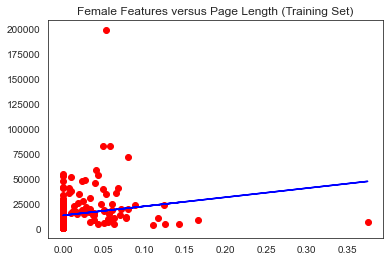

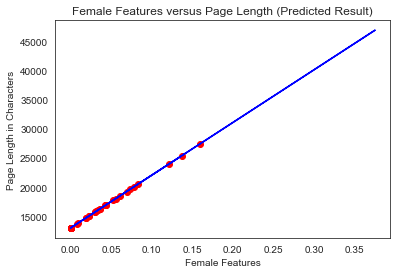

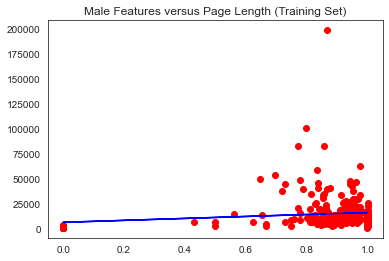

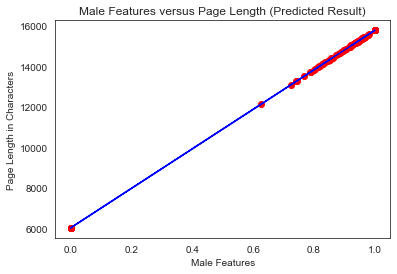

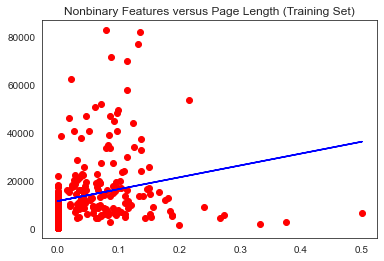

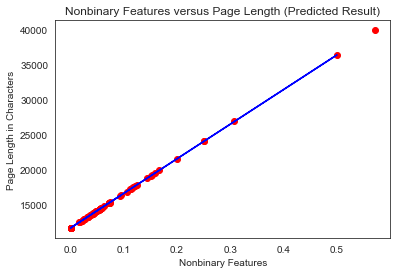

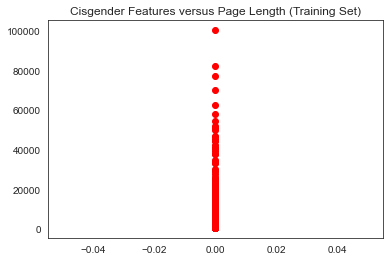

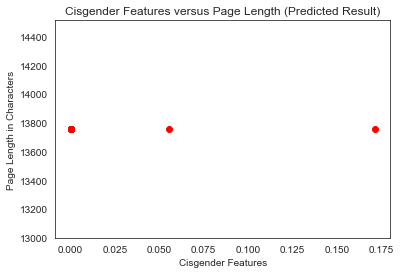

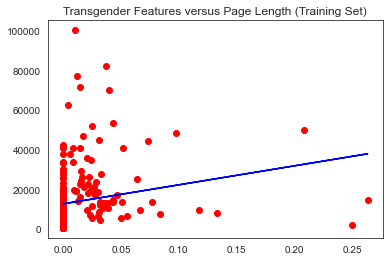

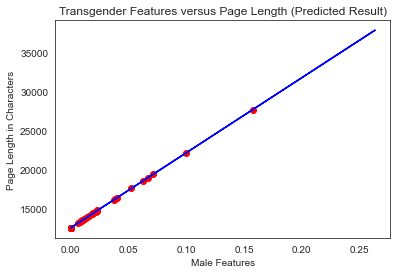

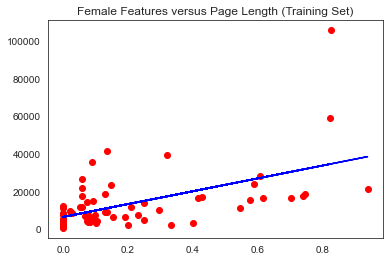

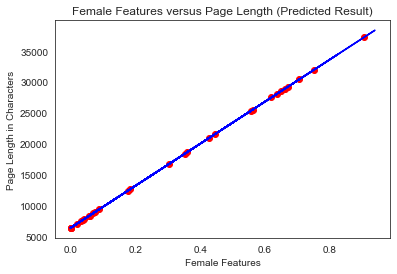

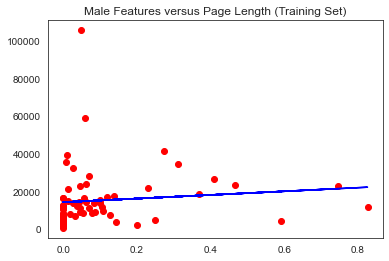

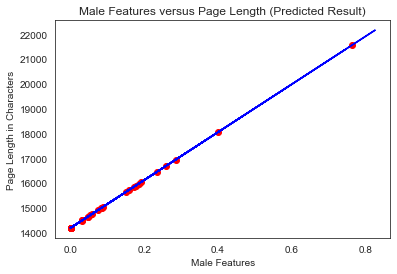

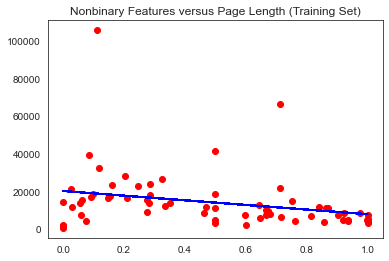

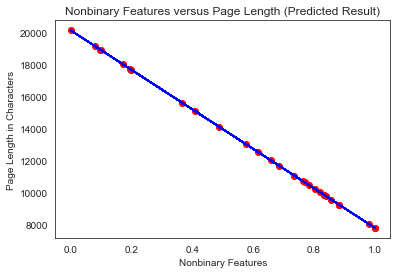

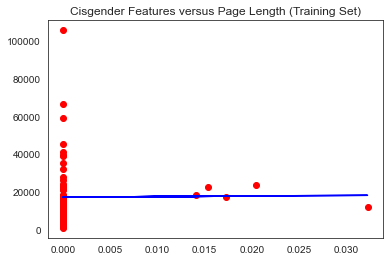

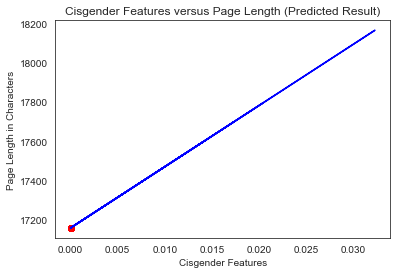

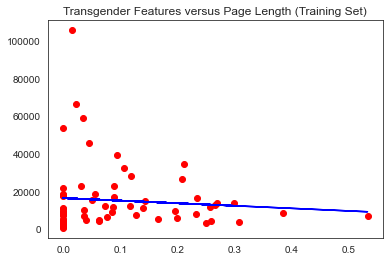

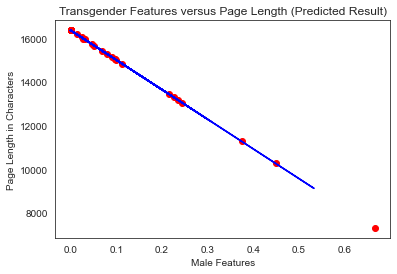

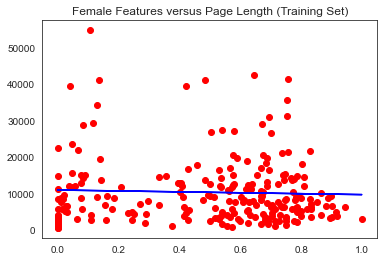

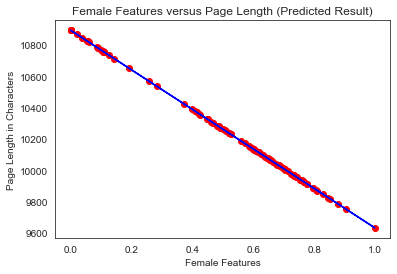

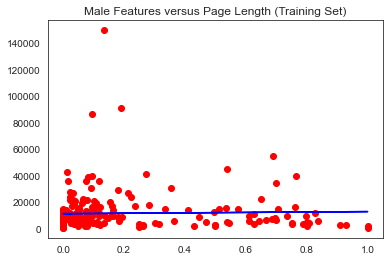

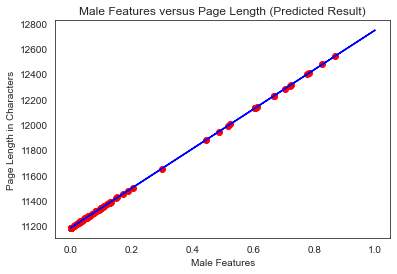

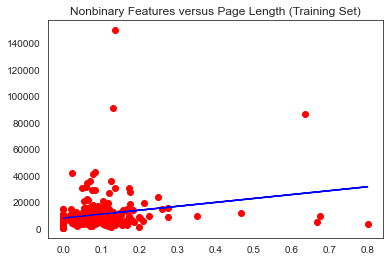

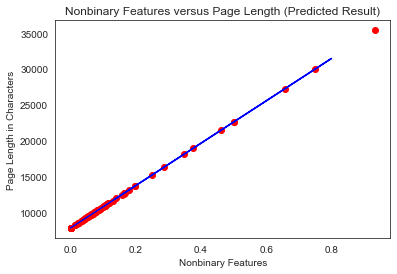

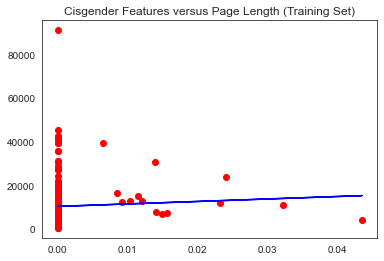

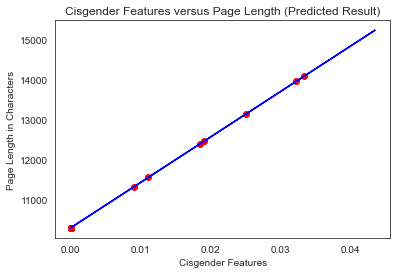

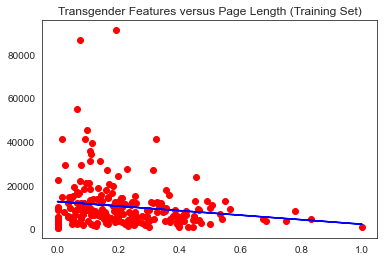

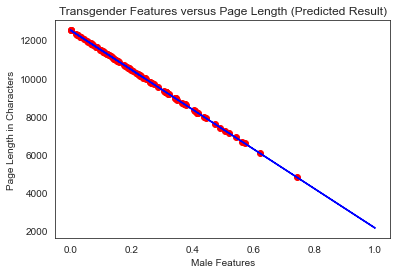

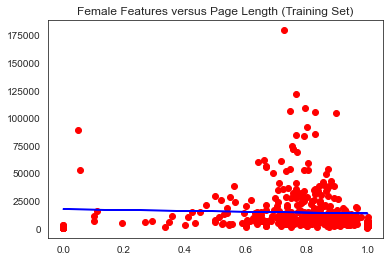

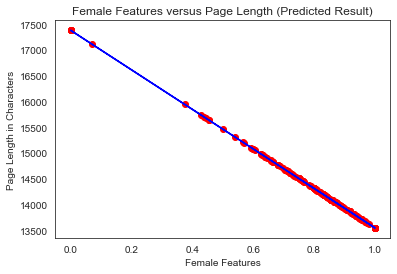

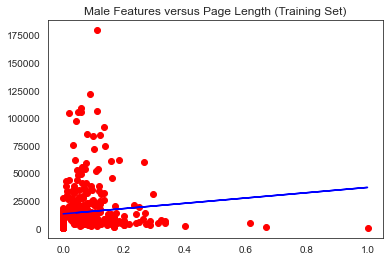

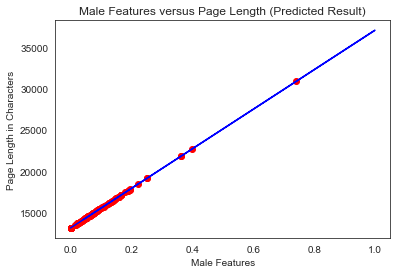

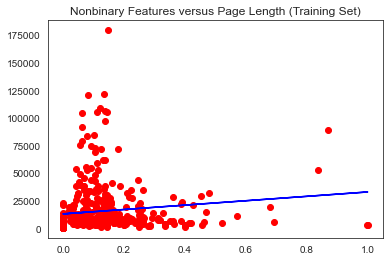

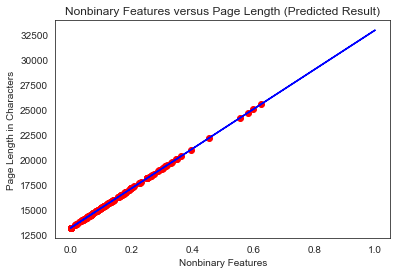

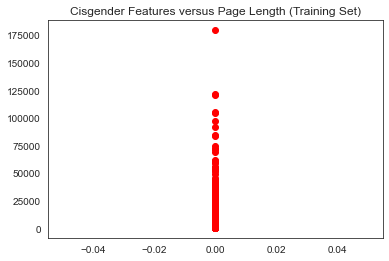

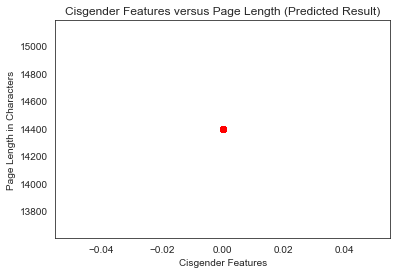

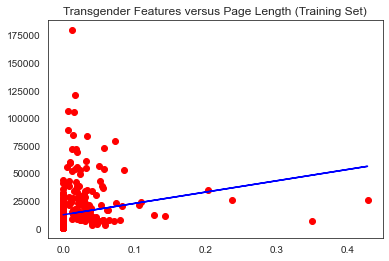

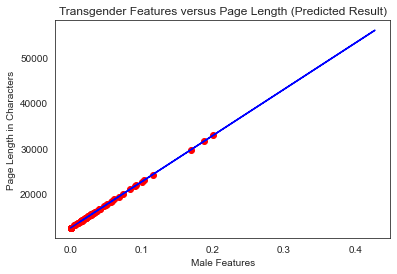

In [37]:
i = 0
while i < 4:
    linearRegression2(allProportions[i])
    i += 1

The baby I never got to use. I love ANOVA tests, but they require normally distributed data. From [Wikipedia:](https://en.wikipedia.org/wiki/Analysis_of_variance)

>   ANOVA is a form of statistical hypothesis testing heavily used in the analysis of experimental data. A test result (calculated from the null hypothesis and the sample) is called statistically significant if it is deemed unlikely to have occurred by chance, assuming the truth of the null hypothesis. A statistically significant result, when a probability (p-value) is less than a pre-specified threshold (significance level), justifies the rejection of the null hypothesis, but only if the a priori probability of the null hypothesis is not high.       
    In the typical application of ANOVA, the null hypothesis is that all groups are random samples from the same population. For example, when studying the effect of different treatments on similar samples of patients, the null hypothesis would be that all treatments have the same effect (perhaps none). Rejecting the null hypothesis is taken to mean that the differences in observed effects between treatment groups are unlikely to be due to random chance.

In [38]:
def ANOVA(proportionDict):
    currentWF = []
    currentMF = []
    currentNBF = []
    currentCisF = []
    currentTransF = []
    
    for person in proportionDict:
        if 'wf' in proportionDict[person]:
            currentWF.append(proportionDict[person]['wf'])
        if 'mf' in proportionDict[person]:
            currentMF.append(proportionDict[person]['mf'])
        if 'nbf' in proportionDict[person]:
            currentNBF.append(proportionDict[person]['nbf'])
        if 'cisf' in proportionDict[person]:
            currentCisF.append(proportionDict[person]['cisf'])
        if 'tf' in proportionDict[person]:
            currentTransF.append(proportionDict[person]['tf'])
    
    print('\tstatistic\t\tpvalue\t\t\t\trandom?')
    
    if (len(currentWF) > 0):
        i,d = randomSample(currentWF,wfProp)
        wfANOVA = stats.f_oneway(i,d)
        print('wf:\t' + str(wfANOVA[0]) + '\t' + str(wfANOVA[1]) + '\t\t' + str(criticalP(wfANOVA[1])))
    else:
        print('No female features found in this dictionary')
    
    if (len(currentMF) > 0):
        i,d = randomSample(currentMF,mfProp)
        mfANOVA = stats.f_oneway(i,d)
        print('mf:\t' + str(mfANOVA[0]) + '\t' + str(mfANOVA[1]) + '\t\t' + str(criticalP(mfANOVA[1])))
    else:
        print('No male features found in this dictionary')
    
    if (len(currentNBF) > 0):
        i,d = randomSample(currentNBF,nbfProp)
        nbfANOVA = stats.f_oneway(i,d)
        print('nbf:\t' + str(nbfANOVA[0]) + '\t' + str(nbfANOVA[1]) + '\t\t' + str(criticalP(nbfANOVA[1])))
    else:
        print('No nonbinary features found in this dictionary')
        
    if (len(currentCisF) > 0):
        i,d = randomSample(currentCisF,cisfProp)
        cisfANOVA = stats.f_oneway(i,d)
        print('cisf:\t' + str(cisfANOVA[0]) + '\t' + str(cisfANOVA[1]) + '\t\t' + str(criticalP(cisfANOVA[1])))
    else:
        print('No cisgender features found in this dictionary')
        
    if (len(currentTransF) > 0):
        i,d = randomSample(currentTransF,transfProp)
        transfANOVA = stats.f_oneway(i,d)
        print('transf:\t' + str(transfANOVA[0]) + '\t' + str(transfANOVA[1]) + '\t\t' + str(criticalP(transfANOVA[1])))
    else:
        print('No binary transgender features found in this dictionary')

/Users/kathrynswint/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
